# ServiceNow Incident Classifier

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, r2_score, balanced_accuracy_score

# models
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import os

nltk.download('stopwords')
nltk.download('punkt')

for directory, subfolders, files in os.walk("data/"):
    for file in files:
        print(os.path.join(directory, file))

data/QAs_Category_SubCategory_Servicenow.csv


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jurie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jurie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
incidents_df = pd.read_csv("data/QAs_Category_SubCategory_Servicenow.csv")

incidents_df.head()

,Category,Subcategory,Question,Answer
0,Inquiry/Help,Antivirus,How to update the antivirus definition files m...,"To manually update antivirus definition files,..."
1,Inquiry/Help,Antivirus,What to do if the antivirus scan is taking too...,"If the antivirus scan is prolonged, check syst..."
2,Inquiry/Help,Antivirus,How to troubleshoot if the antivirus is blocki...,If the antivirus is blocking a legitimate appl...
3,Inquiry/Help,Antivirus,What steps to take if the antivirus is not upd...,If the antivirus fails to update automatically...
4,Inquiry/Help,Antivirus,How to perform a manual antivirus scan on a sp...,"To manually scan a specific folder or file, op..."


## Data Exploration

In [5]:
incidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     190 non-null    object
 1   Subcategory  190 non-null    object
 2   Question     190 non-null    object
 3   Answer       190 non-null    object
dtypes: object(4)
memory usage: 6.1+ KB


In [6]:
print("Number of nulls: ", incidents_df.isna().sum())
print("Number of duplicates: ", incidents_df.duplicated().sum())

Number of nulls:  Category       0
Subcategory    0
Question       0
Answer         0
dtype: int64
Number of duplicates:  2


#### Counts per Category

In [7]:
temp = incidents_df.groupby('Category').count()['Question'].reset_index().sort_values(by="Question", ascending=False)
temp.style.background_gradient(cmap='Purples')

,Category,Question
1,Hardware,60
3,Network,60
2,Inquiry/Help,30
0,Database,20
4,Software,20


<AxesSubplot:xlabel='Category'>

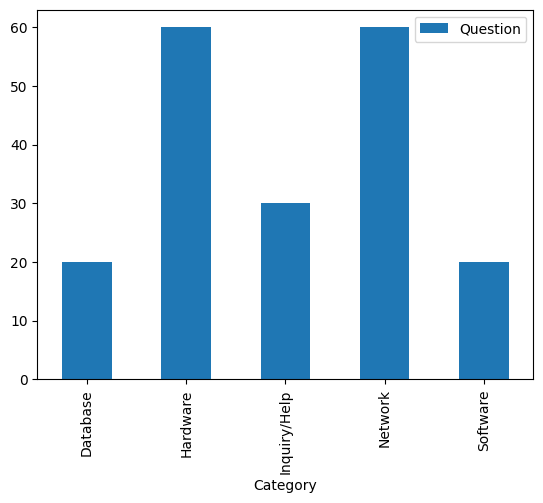

In [11]:
incidents_df.groupby('Category').agg({'Question': 'count'}).plot.bar()

#### Counts per Subcategory

In [8]:
temp = incidents_df.groupby('Subcategory').count()['Question'].reset_index().sort_values(by="Question", ascending=False)
temp.style.background_gradient(cmap='Purples')

,Subcategory,Question
6,Email,20
0,Antivirus,10
10,MS SQL Server,10
16,VPN,10
15,Oracle,10
14,Operating System,10
13,Mouse,10
12,Monitor,10
11,Memory,10
9,Keyboard,10


<AxesSubplot:xlabel='Subcategory'>

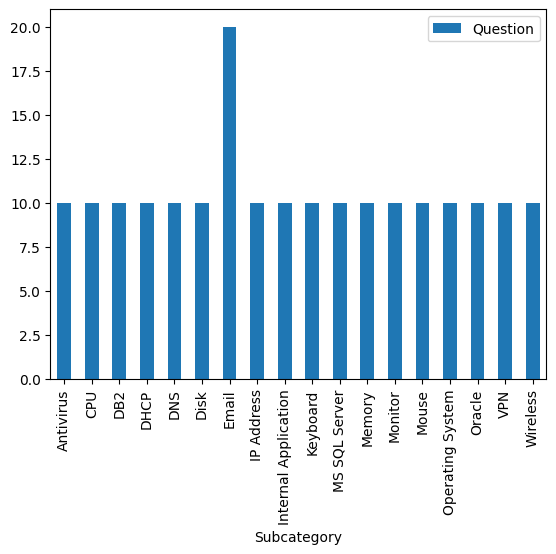

In [12]:
incidents_df.groupby('Subcategory').agg({'Question': 'count'}).plot.bar()

## Data Cleaning

In [13]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links,
        remove punctuations, and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('’', '', text)
    
    return text

### Clean Questions

In [14]:
incidents_df['clean_questions'] = incidents_df['Question'].apply(lambda x: clean_text(x))
incidents_df.head()

,Category,Subcategory,Question,Answer,clean_questions
0,Inquiry/Help,Antivirus,How to update the antivirus definition files m...,"To manually update antivirus definition files,...",how to update the antivirus definition files m...
1,Inquiry/Help,Antivirus,What to do if the antivirus scan is taking too...,"If the antivirus scan is prolonged, check syst...",what to do if the antivirus scan is taking too...
2,Inquiry/Help,Antivirus,How to troubleshoot if the antivirus is blocki...,If the antivirus is blocking a legitimate appl...,how to troubleshoot if the antivirus is blocki...
3,Inquiry/Help,Antivirus,What steps to take if the antivirus is not upd...,If the antivirus fails to update automatically...,what steps to take if the antivirus is not upd...
4,Inquiry/Help,Antivirus,How to perform a manual antivirus scan on a sp...,"To manually scan a specific folder or file, op...",how to perform a manual antivirus scan on a sp...


### Clean Answers

In [15]:
incidents_df['clean_answers'] = incidents_df['Answer'].apply(lambda x: clean_text(x))
incidents_df.head()

,Category,Subcategory,Question,Answer,clean_questions,clean_answers
0,Inquiry/Help,Antivirus,How to update the antivirus definition files m...,"To manually update antivirus definition files,...",how to update the antivirus definition files m...,to manually update antivirus definition files ...
1,Inquiry/Help,Antivirus,What to do if the antivirus scan is taking too...,"If the antivirus scan is prolonged, check syst...",what to do if the antivirus scan is taking too...,if the antivirus scan is prolonged check syste...
2,Inquiry/Help,Antivirus,How to troubleshoot if the antivirus is blocki...,If the antivirus is blocking a legitimate appl...,how to troubleshoot if the antivirus is blocki...,if the antivirus is blocking a legitimate appl...
3,Inquiry/Help,Antivirus,What steps to take if the antivirus is not upd...,If the antivirus fails to update automatically...,what steps to take if the antivirus is not upd...,if the antivirus fails to update automatically...
4,Inquiry/Help,Antivirus,How to perform a manual antivirus scan on a sp...,"To manually scan a specific folder or file, op...",how to perform a manual antivirus scan on a sp...,to manually scan a specific folder or file ope...


## Model Development

We'll be building two models:
1. First model will predict the `Category` of the `Question` incident
2. Second model will use the predicted `Category` and the `Question` incident to predict the `Subcategory`

### Building the Incident Category Classifier 

In [486]:
X_category_incidents = incidents_df['clean_questions']
y_category_incidents = incidents_df['Category']

In [487]:
from sklearn.model_selection import train_test_split

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_category_incidents, y_category_incidents, test_size=0.2, stratify=incidents_df['Category'], random_state=42)

X_cat_train = X_cat_train.reset_index(drop=True)
X_cat_test = X_cat_test.reset_index(drop=True)
y_cat_train = y_cat_train.reset_index(drop=True)
y_cat_test = y_cat_test.reset_index(drop=True)

print("X_cat_train: ", X_cat_train.shape)
print("X_cat_test: ", X_cat_test.shape)

X_cat_train:  (152,)
X_cat_test:  (38,)


In [488]:
subcategories = {'Antivirus': 0, 'Email': 1, 'Internal Application': 2, 'Operating System': 3,
                 'CPU': 4, 'Disk': 5, 'Keyboard': 6, 'Memory': 7, 'Monitor': 8, 'Mouse': 9,
                 'DHCP': 10, 'Wireless': 11, 'DB2': 12, 'MS SQL Server': 13, 'DNS': 14,
                 'IP Address': 15, 'VPN': 16, 'Oracle': 17}

train_list_subcategories = []
test_list_subcategories = []

for incident in X_cat_train.tolist():
    train_list_subcategories.append(incidents_df.loc[incidents_df['clean_questions'].str.match(incident)]['Subcategory'].values[0])

for incident in X_cat_test.tolist():
    test_list_subcategories.append(incidents_df.loc[incidents_df['clean_questions'].str.match(incident)]['Subcategory'].values[0])

train_list_subcategories_series = pd.Series(train_list_subcategories).map(subcategories)
test_list_subcategories_series = pd.Series(test_list_subcategories).map(subcategories)

### Preprocess Text

In [489]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

def preprocess_text(text):
    '''
        Function for text preprocessing
    '''

    cleaned = re.sub(r"\W+", '', text).lower() # removes punctuation
    cleaned = re.sub('•', '', text)
    tokenized = word_tokenize(cleaned) # tokenization of text

    # stop words removal
    en_stopwords = set(stopwords.words('english'))
    no_stops = [token for token in tokenized if token not in en_stopwords]

    stemmer = PorterStemmer()
    stemmed = " ".join([stemmer.stem(token) for token in no_stops])

    return stemmed

In [490]:
X_cat_train = X_cat_train.apply(preprocess_text)
print(X_cat_train.shape)
X_cat_train.head()

(152,)


0                step take email sync mobil devic
1            step take mous button work correctli
2                troubleshoot issu authent failur
3             step take dead pixel monitor screen
4    resolv issu sql server instanc crash unavail
Name: clean_questions, dtype: object

In [491]:
X_cat_test = X_cat_test.apply(preprocess_text)
print(X_cat_test.shape)
X_cat_test.head()

(38,)


0    step take devic unabl connect wireless network
1    step take encount email respond messag softwar
2                        step take oper system boot
3            devic receiv incorrect ip address dhcp
4                     monitor recogn system hardwar
Name: clean_questions, dtype: object

In [492]:
import joblib

category_vectorizer = TfidfVectorizer(norm=None, max_features=200)

X_values_list = category_vectorizer.fit_transform(X_cat_train).toarray()
X_cat_train = pd.DataFrame(X_values_list, columns = category_vectorizer.get_feature_names_out())

X_values_list = category_vectorizer.transform(X_cat_test).toarray()
X_cat_test = pd.DataFrame(X_values_list, columns=category_vectorizer.get_feature_names_out())

# X_cat_train['category'] = train_list_subcategories_series
# X_cat_test['category'] = test_list_subcategories_series

# save the vectorizer for model inference
vectorizer_name = "category_vectorizer.joblib"
joblib.dump(category_vectorizer, os.path.join("models", vectorizer_name))

X_cat_train.head()

,abnorm,access,account,address,agent,allow,amount,antiviru,applic,assign,...,util,visibl,vpn,warn,weak,wheel,window,wireless,within,work
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.644144
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### Model Training

In [493]:
models = [
    LogisticRegression(),
    MLPClassifier(),
    KNeighborsClassifier(),
    SVC(),
#     GaussianProcessClassifier(),
    QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB()
]

In [494]:
incidents_df['Category'].unique().tolist()

['Inquiry/Help', 'Software', 'Hardware', 'Network', 'Database']

In [495]:
categories = {'Inquiry/Help': 0, 'Software': 1, 'Hardware': 2, 'Network': 3, 'Database': 4}

y_cat_train = y_cat_train.map(categories)
y_cat_test = y_cat_test.map(categories)

y_cat_train

0      0
1      2
2      4
3      2
4      4
      ..
147    2
148    2
149    1
150    3
151    4
Name: Category, Length: 152, dtype: int64

In [496]:
category_evaluation_scores = {
    'model': models,
    'test_accuracy': [],
    'macro_f1_score': [],
    'test_r2_score': []
}

LogisticRegression()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         4

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



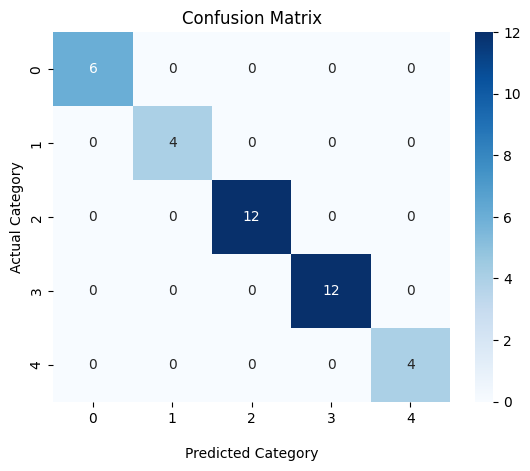

MLPClassifier()
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.60      0.75      0.67         4
           2       1.00      1.00      1.00        12
           3       0.92      1.00      0.96        12
           4       1.00      1.00      1.00         4

    accuracy                           0.92        38
   macro avg       0.90      0.88      0.89        38
weighted avg       0.93      0.92      0.92        38



c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



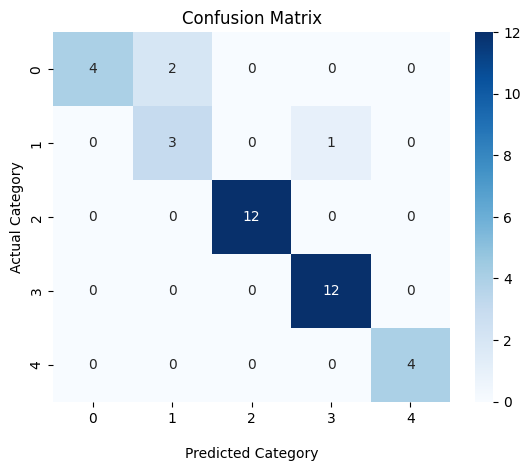

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.38      0.50      0.43         6
           1       0.29      0.50      0.36         4
           2       0.89      0.67      0.76        12
           3       0.80      0.67      0.73        12
           4       0.50      0.50      0.50         4

    accuracy                           0.61        38
   macro avg       0.57      0.57      0.56        38
weighted avg       0.68      0.61      0.63        38



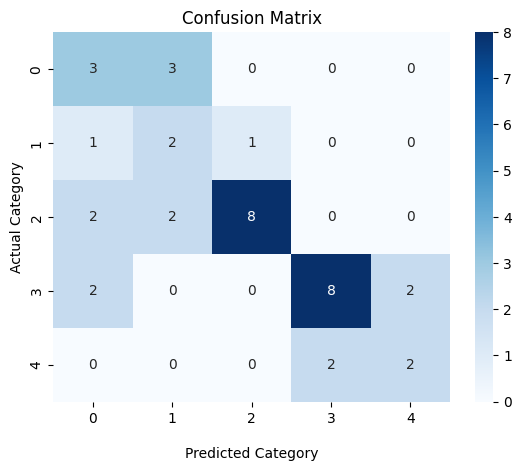

SVC()
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.50      0.25      0.33         4
           2       0.80      1.00      0.89        12
           3       0.92      1.00      0.96        12
           4       1.00      0.75      0.86         4

    accuracy                           0.87        38
   macro avg       0.84      0.77      0.79        38
weighted avg       0.86      0.87      0.85        38



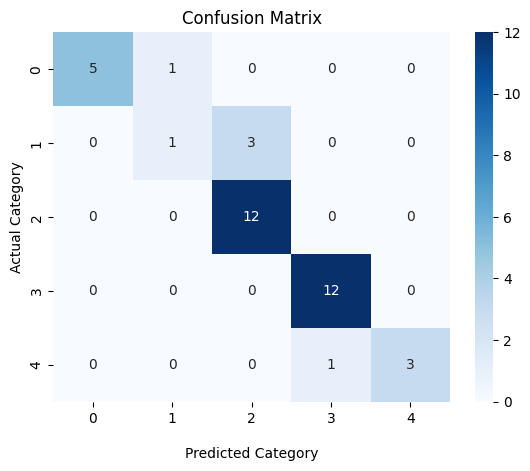

QuadraticDiscriminantAnalysis()
              precision    recall  f1-score   support

           0       0.20      0.67      0.31         6
           1       0.40      0.50      0.44         4
           2       0.33      0.08      0.13        12
           3       0.80      0.33      0.47        12
           4       0.80      1.00      0.89         4

    accuracy                           0.39        38
   macro avg       0.51      0.52      0.45        38
weighted avg       0.52      0.39      0.38        38



c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning:

Variables are collinear



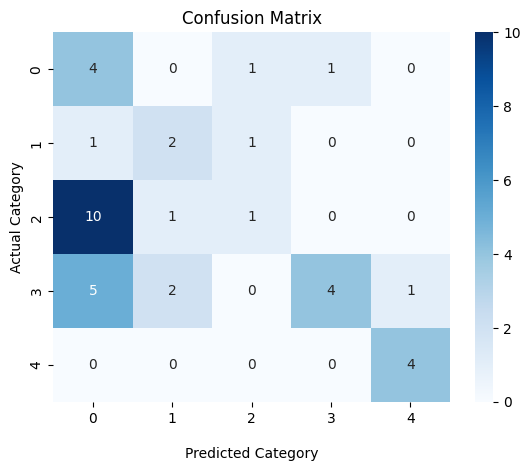

DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        12
           3       0.91      0.83      0.87        12
           4       0.60      0.75      0.67         4

    accuracy                           0.92        38
   macro avg       0.90      0.92      0.91        38
weighted avg       0.93      0.92      0.92        38



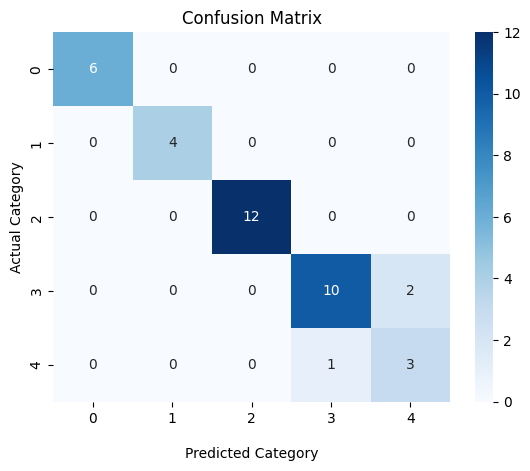

RandomForestClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        12
           3       0.92      1.00      0.96        12
           4       1.00      0.75      0.86         4

    accuracy                           0.97        38
   macro avg       0.98      0.95      0.96        38
weighted avg       0.98      0.97      0.97        38



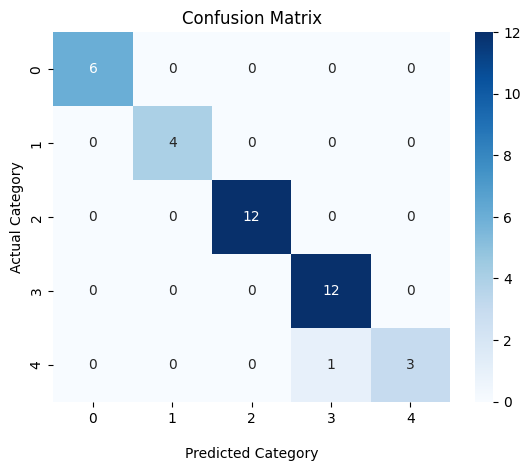

AdaBoostClassifier()
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       1.00      0.75      0.86         4
           2       0.35      1.00      0.52        12
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         4

    accuracy                           0.39        38
   macro avg       0.27      0.35      0.28        38
weighted avg       0.22      0.39      0.25        38



c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



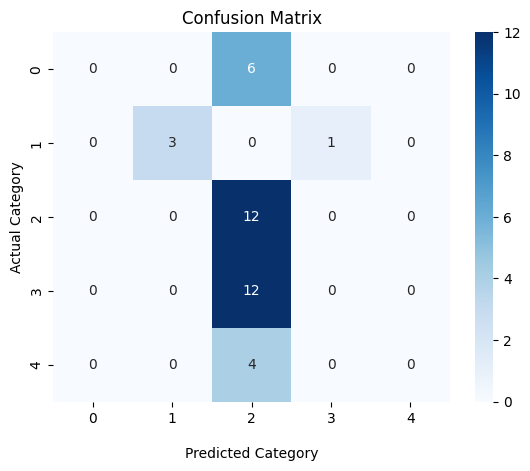

GaussianNB()
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.00      0.00      0.00         4
           2       0.91      0.83      0.87        12
           3       1.00      0.92      0.96        12
           4       0.67      1.00      0.80         4

    accuracy                           0.71        38
   macro avg       0.60      0.62      0.60        38
weighted avg       0.74      0.71      0.72        38



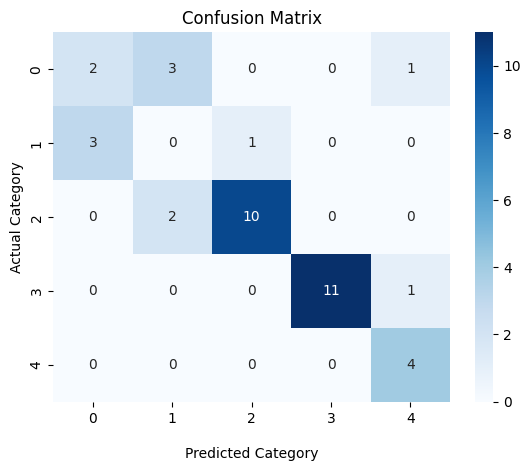

In [497]:
for model in models:
    model.fit(X_cat_train, y_cat_train)
    y_pred = model.predict(X_cat_test)
    
    print(str(model))
    # show results in conf matrix
    cf_matrix = confusion_matrix(y_cat_test, y_pred)
    
    disp_cf = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
    
    disp_cf.set_title('Confusion Matrix')
    disp_cf.set_xlabel("\nPredicted Category")
    disp_cf.set_ylabel("Actual Category")
    
    test_accuracy = balanced_accuracy_score(y_cat_test, y_pred)
    test_r2_score = r2_score(y_cat_test, y_pred)
    macro_f1_score = f1_score(y_cat_test, y_pred, average='macro')
    
    category_evaluation_scores['test_accuracy'].append(test_accuracy)
    category_evaluation_scores['test_r2_score'].append(test_r2_score)
    category_evaluation_scores['macro_f1_score'].append(macro_f1_score)
    
    print(classification_report(y_cat_test, y_pred))
    plt.show()

### Evaluation of Category Classifier

In [498]:
category_evaluation_scores = pd.DataFrame(category_evaluation_scores)
category_evaluation_scores.style.background_gradient(cmap='Blues')

,model,test_accuracy,macro_f1_score,test_r2_score
0,LogisticRegression(),1.000000,1.000000,1.000000
1,MLPClassifier(),0.883333,0.885333,0.892045
2,KNeighborsClassifier(),0.566667,0.556277,0.334280
3,SVC(),0.766667,0.789691,0.910038
4,QuadraticDiscriminantAnalysis(),0.516667,0.448989,-0.979167
5,DecisionTreeClassifier(),0.916667,0.907246,0.946023
6,RandomForestClassifier(),0.950000,0.963429,0.982008
7,AdaBoostClassifier(),0.350000,0.275776,-0.007576
8,GaussianNB(),0.616667,0.597945,0.532197


### Saving the Category Classifier

There are 2 best models for incident classification, lets save both the Random Forest Classifier, and Logistic Regression.

test accuracy:  1.0
test r2 score:  1.0
macro f1 score:  1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         4

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



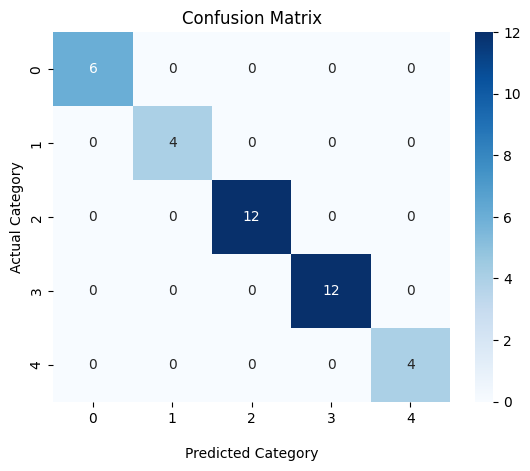

In [499]:
import joblib

category_model1 = LogisticRegression()
category_model1.fit(X_cat_train, y_cat_train)

y_pred = category_model1.predict(X_cat_test)

cf_matrix = confusion_matrix(y_cat_test, y_pred)
disp_cf = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

disp_cf.set_title('Confusion Matrix')
disp_cf.set_xlabel("\nPredicted Category")
disp_cf.set_ylabel("Actual Category")

print("test accuracy: ", balanced_accuracy_score(y_cat_test, y_pred))
print("test r2 score: ", r2_score(y_cat_test, y_pred))
print("macro f1 score: ", f1_score(y_cat_test, y_pred, average='macro'))
print()
print(classification_report(y_cat_test, y_pred))

filename = 'incident_category_lr_clf.joblib'
joblib.dump(category_model1, os.path.join("models", filename))

plt.show()

test accuracy:  0.95
test r2 score:  0.9820075757575758
macro f1 score:  0.9634285714285713

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        12
           3       0.92      1.00      0.96        12
           4       1.00      0.75      0.86         4

    accuracy                           0.97        38
   macro avg       0.98      0.95      0.96        38
weighted avg       0.98      0.97      0.97        38



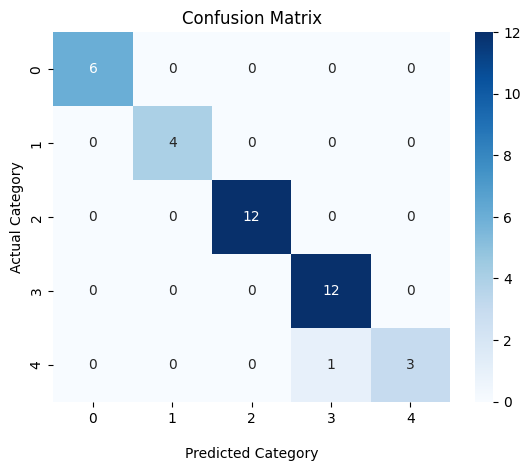

In [500]:
category_model2 = RandomForestClassifier()
category_model2.fit(X_cat_train, y_cat_train)

y_pred = category_model2.predict(X_cat_test)

cf_matrix = confusion_matrix(y_cat_test, y_pred)
disp_cf = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

disp_cf.set_title('Confusion Matrix')
disp_cf.set_xlabel("\nPredicted Category")
disp_cf.set_ylabel("Actual Category")

print("test accuracy: ", balanced_accuracy_score(y_cat_test, y_pred))
print("test r2 score: ", r2_score(y_cat_test, y_pred))
print("macro f1 score: ", f1_score(y_cat_test, y_pred, average='macro'))
print()
print(classification_report(y_cat_test, y_pred))

filename = 'incident_category_rf_clf.joblib'
joblib.dump(category_model2, os.path.join("models", filename))

plt.show()

### Building the Incident Subcategory Classifier 

In [520]:
X_subcategory_incidents = incidents_df['clean_questions']
y_subcategory_incidents = incidents_df['Subcategory']

In [521]:
X_subcat_train, X_subcat_test, y_subcat_train, y_subcat_test = train_test_split(X_subcategory_incidents, y_subcategory_incidents, test_size=0.2, stratify=incidents_df['Subcategory'], random_state=42)

X_subcat_test = X_subcat_test.reset_index(drop=True)
y_subcat_test = y_subcat_test.reset_index(drop=True)
X_subcat_train = X_subcat_train.reset_index(drop=True)
y_subcat_train = y_subcat_train.reset_index(drop=True)

print("X_subcat_train: ", X_subcat_train.shape)
print("X_subcat_test: ", X_subcat_test.shape)

X_subcat_train:  (152,)
X_subcat_test:  (38,)


Get list of categories per partition

We will be appending this list to the vectorized dataframe

In [522]:
categories = {'Inquiry/Help': 0, 'Software': 1, 'Hardware': 2, 'Network': 3, 'Database': 4}

train_list_categories = []
test_list_categories = []
for incident in X_subcat_train.tolist():
    train_list_categories.append(incidents_df.loc[incidents_df['clean_questions'].str.match(incident)]['Category'].values[0])

for incident in X_subcat_test.tolist():
    test_list_categories.append(incidents_df.loc[incidents_df['clean_questions'].str.match(incident)]['Category'].values[0])
    
print(train_list_categories[:5])
print(test_list_categories[:5])

train_list_categories_series = pd.Series(train_list_categories).map(categories)
test_list_categories_series = pd.Series(test_list_categories).map(categories)

print(train_list_categories_series[:5])
print(test_list_categories_series[:5])

['Hardware', 'Hardware', 'Hardware', 'Network', 'Inquiry/Help']
['Hardware', 'Inquiry/Help', 'Hardware', 'Hardware', 'Network']
0    2
1    2
2    2
3    3
4    0
dtype: int64
0    2
1    0
2    2
3    2
4    3
dtype: int64


In [523]:
X_subcat_train = X_subcat_train.apply(preprocess_text)
print(X_subcat_train.shape)
X_subcat_train.head()

(152,)


0              troubleshoot issu cpu core util hardwar
1    troubleshoot issu multimedia key function keyb...
2                  step take dead pixel monitor screen
3    troubleshoot issu devic releas ip address prop...
4                 resolv send email error email client
Name: clean_questions, dtype: object

In [524]:
X_subcat_test = X_subcat_test.apply(preprocess_text)
print(X_subcat_test.shape)
X_subcat_test.head()

(38,)


0     resolv system instabl caus memori conflict
1               exclud file folder antiviru scan
2                    troubleshoot data loss disk
3    troubleshoot unrespons key keyboard hardwar
4        step take devic experi delay dn resolut
Name: clean_questions, dtype: object

In [525]:
subcategory_vectorizer = TfidfVectorizer(norm=None, max_features=200)

X_values_list = subcategory_vectorizer.fit_transform(X_subcat_train).toarray()
X_subcat_train = pd.DataFrame(X_values_list, columns = subcategory_vectorizer.get_feature_names_out())

X_values_list = subcategory_vectorizer.transform(X_subcat_test).toarray()
X_subcat_test = pd.DataFrame(X_values_list, columns=subcategory_vectorizer.get_feature_names_out())

vectorizer_name = "subcategory_vectorizer.joblib"
joblib.dump(subcategory_vectorizer, os.path.join("models", vectorizer_name))

X_subcat_train['category'] = train_list_categories_series
X_subcat_test['category'] = test_list_categories_series

X_subcat_train.head()

,abnorm,access,account,address,amount,antiviru,applic,assign,attach,authent,...,visibl,vpn,warn,weak,wheel,window,wireless,within,work,category
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,3.391381,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [526]:
models = [
    LogisticRegression(),
    MLPClassifier(),
    KNeighborsClassifier(),
    SVC(),
#     GaussianProcessClassifier(),
    QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB()
]

In [527]:
incidents_df['Subcategory'].unique().tolist()

['Antivirus',
 'Email',
 'Internal Application',
 'Operating System',
 'CPU',
 'Disk',
 'Keyboard',
 'Memory',
 'Monitor',
 'Mouse',
 'DHCP',
 'Wireless',
 'DB2',
 'MS SQL Server',
 'DNS',
 'IP Address',
 'VPN',
 'Oracle']

In [528]:
subcategories = {'Antivirus': 0, 'Email': 1, 'Internal Application': 2, 'Operating System': 3,
                 'CPU': 4, 'Disk': 5, 'Keyboard': 6, 'Memory': 7, 'Monitor': 8, 'Mouse': 9,
                 'DHCP': 10, 'Wireless': 11, 'DB2': 12, 'MS SQL Server': 13, 'DNS': 14,
                 'IP Address': 15, 'VPN': 16, 'Oracle': 17}

y_subcat_train = y_subcat_train.map(subcategories)
y_subcat_test = y_subcat_test.map(subcategories)

y_subcat_train

0       4
1       6
2       8
3      15
4       1
       ..
147     3
148    17
149    13
150     3
151     2
Name: Subcategory, Length: 152, dtype: int64

In [529]:
subcategory_evaluation_scores = {
    'model': models,
    'test_accuracy': [],
    'macro_f1_score': [],
    'test_r2_score': []
}

LogisticRegression()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       0.50      0.50      0.50         2
          11       0.67      1.00      0.80         2
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       0.50      0.50      0.50         2
          16       0.67      1.00      0.80         2
      

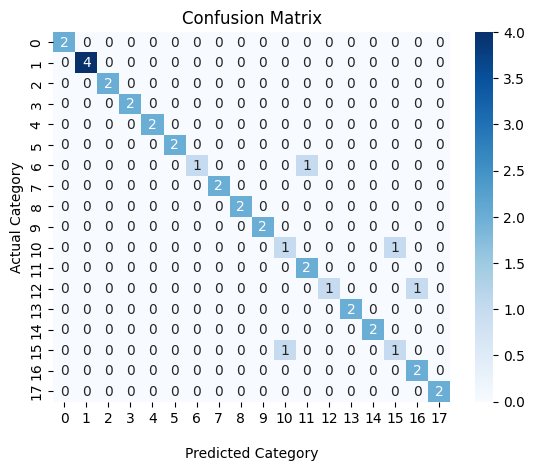

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       0.50      0.50      0.50         2
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       0.50      0.50      0.50         2
          16       0.50      1.00      0.67         2
          1

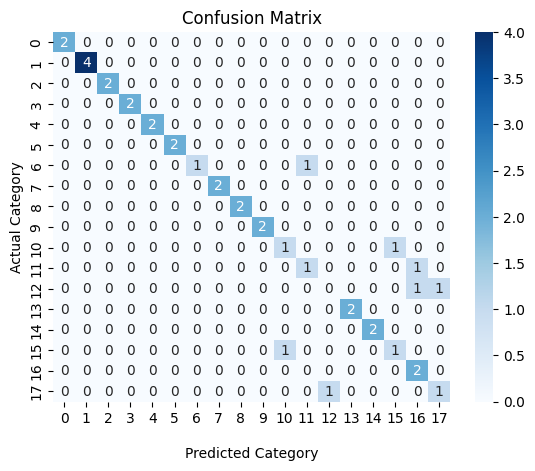

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.44      1.00      0.62         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       0.67      1.00      0.80         2
           5       1.00      0.50      0.67         2
           6       1.00      0.50      0.67         2
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       0.67      1.00      0.80         2
          11       0.50      0.50      0.50         2
          12       0.00      0.00      0.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67         2
          16       1.00      0.50      0.67         2
    

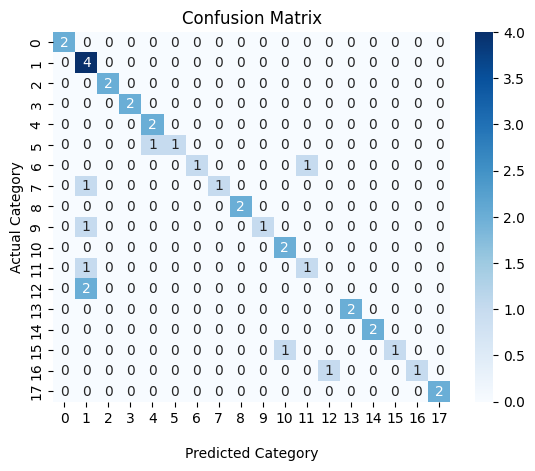

SVC()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       0.50      0.50      0.50         2
          11       0.67      1.00      0.80         2
          12       0.00      0.00      0.00         2
          13       0.50      0.50      0.50         2
          14       1.00      1.00      1.00         2
          15       0.50      0.50      0.50         2
          16       0.67      1.00      0.80         2
          17       1.

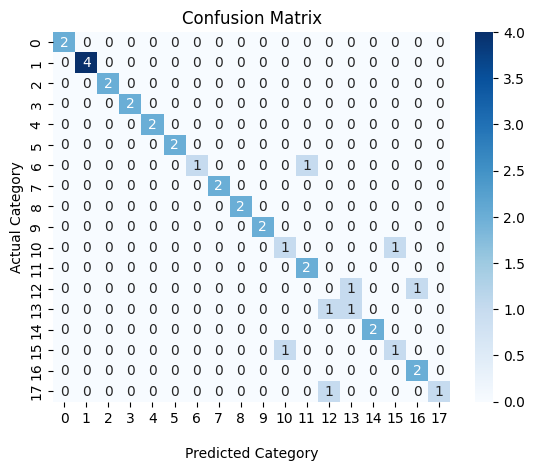

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning:

Variables are collinear

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



QuadraticDiscriminantAnalysis()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         2
          13       0.33      0.50      0.40         2
          14       1.00      0.50      0.67         2
          15       0.50      0.50      0.50         2
          16       1.00      1.00      1.00      

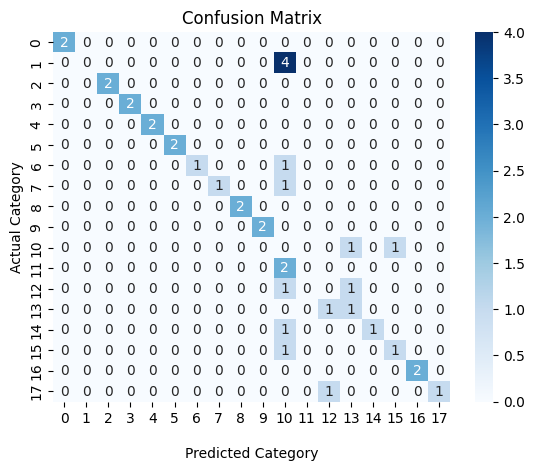

DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       0.50      0.50      0.50         2
          11       0.67      1.00      0.80         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       0.50      0.50      0.50         2
          16       1.00      1.00      1.00         2
  

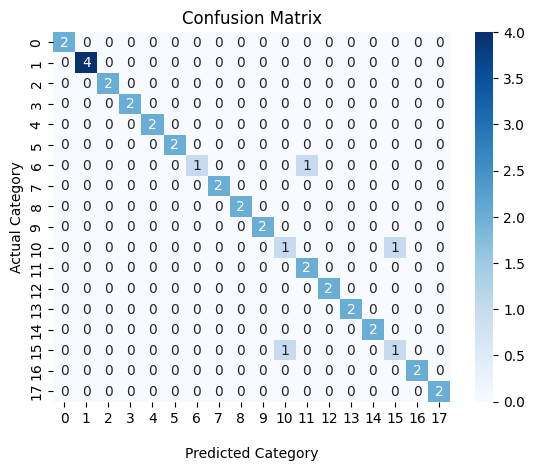

RandomForestClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       0.67      1.00      0.80         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67         2
          16       1.00      1.00      1.00         2
  

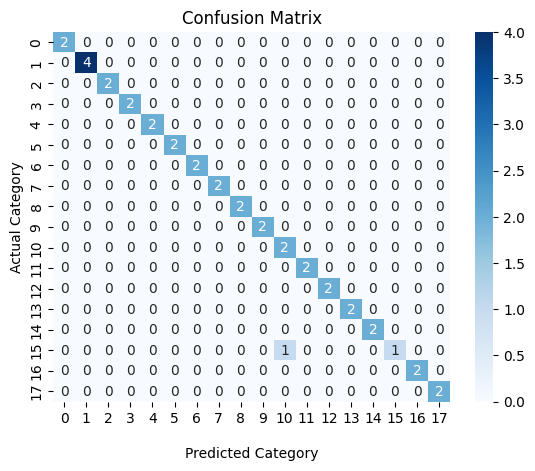

AdaBoostClassifier()


c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       0.12      1.00      0.22         2
           5       0.00      0.00      0.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         2
           9       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         2
          12       0.50      1.00      0.67         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
          16       1.00      1.00      1.00         2
          17       0.00    

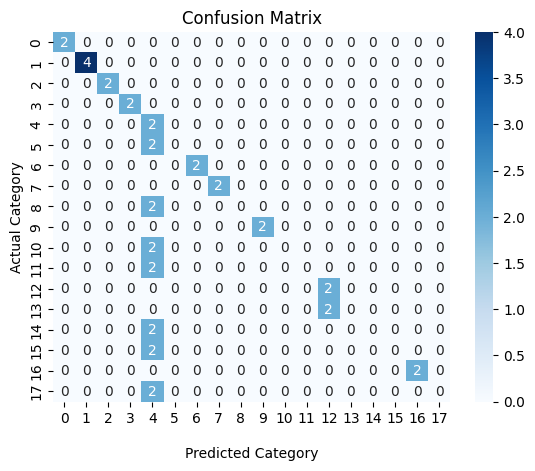

GaussianNB()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.67      1.00      0.80         4
           2       1.00      1.00      1.00         2
           3       1.00      0.50      0.67         2
           4       0.67      1.00      0.80         2
           5       0.00      0.00      0.00         2
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       0.67      1.00      0.80         2
          10       1.00      0.50      0.67         2
          11       1.00      0.50      0.67         2
          12       0.00      0.00      0.00         2
          13       0.33      0.50      0.40         2
          14       1.00      1.00      1.00         2
          15       0.67      1.00      0.80         2
          16       1.00      0.50      0.67         2
          17  

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\jurie\anaconda3\envs\mle\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



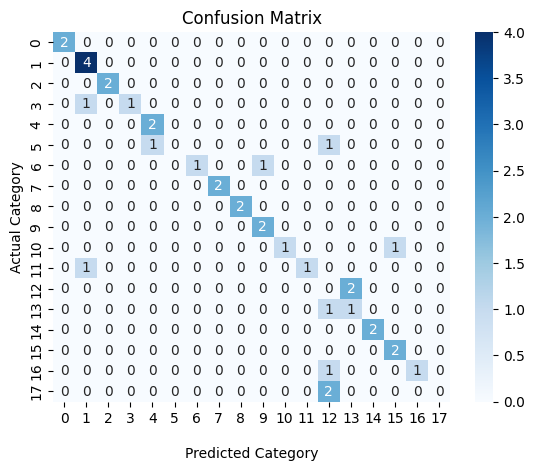

In [530]:
for model in models:
    model.fit(X_subcat_train, y_subcat_train)
    y_pred = model.predict(X_subcat_test)
    
    print(str(model))
    # show results in conf matrix
    cf_matrix = confusion_matrix(y_subcat_test, y_pred)
    
    disp_cf = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
    
    disp_cf.set_title('Confusion Matrix')
    disp_cf.set_xlabel("\nPredicted Category")
    disp_cf.set_ylabel("Actual Category")
    
    test_accuracy = balanced_accuracy_score(y_subcat_test, y_pred)
    test_r2_score = r2_score(y_subcat_test, y_pred)
    macro_f1_score = f1_score(y_subcat_test, y_pred, average='macro')
    
    subcategory_evaluation_scores['test_accuracy'].append(test_accuracy)
    subcategory_evaluation_scores['test_r2_score'].append(test_r2_score)
    subcategory_evaluation_scores['macro_f1_score'].append(macro_f1_score)
    
    print(classification_report(y_subcat_test, y_pred))
    plt.show()

### Evaluation of Subcategory Classifier

In [531]:
subcategory_evaluation_scores = pd.DataFrame(subcategory_evaluation_scores)
subcategory_evaluation_scores.style.background_gradient(cmap='Blues')

,model,test_accuracy,macro_f1_score,test_r2_score
0,LogisticRegression(),0.888889,0.885185,0.915394
1,MLPClassifier(),0.805556,0.796296,0.845665
2,KNeighborsClassifier(),0.750000,0.761966,0.526766
3,SVC(),0.805556,0.801852,0.890292
4,QuadraticDiscriminantAnalysis(),0.611111,0.642593,0.575113
5,DecisionTreeClassifier(),0.916667,0.914815,0.930270
6,RandomForestClassifier(),0.972222,0.970370,0.976757
7,AdaBoostClassifier(),0.555556,0.493827,0.083284
8,GaussianNB(),0.666667,0.662963,0.761059


test accuracy:  0.9444444444444444
test r2 score:  0.953513407711881
macro f1 score:  0.9444444444444444

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       0.50      0.50      0.50         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       0.50      

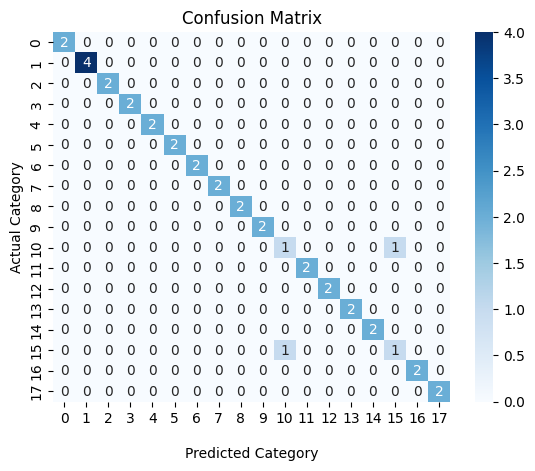

In [532]:
import joblib
subcat_model = RandomForestClassifier()
subcat_model.fit(X_subcat_train, y_subcat_train)

y_pred = subcat_model.predict(X_subcat_test)

cf_matrix = confusion_matrix(y_subcat_test, y_pred)
disp_cf = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

disp_cf.set_title('Confusion Matrix')
disp_cf.set_xlabel("\nPredicted Category")
disp_cf.set_ylabel("Actual Category")

print("test accuracy: ", balanced_accuracy_score(y_subcat_test, y_pred))
print("test r2 score: ", r2_score(y_subcat_test, y_pred))
print("macro f1 score: ", f1_score(y_subcat_test, y_pred, average='macro'))
print()
print(classification_report(y_subcat_test, y_pred))

filename = "incident_subcategory_rf_clf.joblib"
joblib.dump(subcat_model, os.path.join("models", filename))

plt.show()

## Model Inference

We'll be testing the two models created
1. The first model will take the text prompt and predict the category of the incident.
2. Then the second model will use the text prompt and the predicted category to predict the subcategory of the incident.
3. We'll be using a sample prompt from the test data to compare the result.

### Collect all preprocessing functions

In [533]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import joblib

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links,
        remove punctuations, and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('’', '', text)
    
    return text

def preprocess_text(text):
    '''
        Function for text preprocessing
    '''
    
    cleaned = re.sub(r'\W+', '', text).lower() # removes punctuation
    cleaned = re.sub('•', '', text)
    tokenized = word_tokenize(cleaned) # tokenization of text
    
    # stop words removal
    en_stopwords = set(stopwords.words('english'))
    no_stops = [token for token in tokenized if token not in en_stopwords]

#     print(no_stops)
    # stemming
    stemmer = PorterStemmer()
    stemmed = " ".join([stemmer.stem(token) for token in no_stops])
    
    return stemmed


### Load the models and vectorizers

In [539]:

category_vectorizer = joblib.load("models/category_vectorizer.joblib")
subcategory_vectorizer = joblib.load("models/subcategory_vectorizer.joblib")
category_classifier1 = joblib.load("models/incident_category_lr_clf.joblib")
category_classifier2 = joblib.load("models/incident_category_rf_clf.joblib")
subcategory_classifier = joblib.load("models/incident_subcategory_rf_clf.joblib")

In [540]:
X_incidents = incidents_df['Question']
y_cat_incidents = incidents_df['Category']
y_subcat_incidents = incidents_df['Subcategory']

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_incidents, y_cat_incidents, test_size=0.2, stratify=incidents_df['Category'], random_state=0)
X_subcat_train, X_subcat_test, y_subcat_train, y_subcat_test = train_test_split(X_incidents, y_subcat_incidents, test_size=0.2, stratify=incidents_df['Subcategory'], random_state=0)

X_cat_test = X_cat_test.reset_index(drop=True)
y_cat_test = y_cat_test.reset_index(drop=True)
X_subcat_test = X_subcat_test.reset_index(drop=True)
y_subcat_test = y_subcat_test.reset_index(drop=True)

rand_idx = np.random.randint(0, 37)
print("Incident: ", X_cat_test[rand_idx])
print("Category: ", y_cat_test[rand_idx])
print("Subcategory: ", incidents_df.loc[incidents_df['Question'].isin([X_cat_test[rand_idx]])]['Subcategory'].values[0])

Incident:  What to do if there are issues with disk read/write errors?
Category:  Hardware
Subcategory:  Disk


In [542]:
categories = {'Inquiry/Help': 0, 'Software': 1, 'Hardware': 2, 'Network': 3, 'Database': 4}
subcategories = {'Antivirus': 0, 'Email': 1, 'Internal Application': 2, 'Operating System': 3,
                 'CPU': 4, 'Disk': 5, 'Keyboard': 6, 'Memory': 7, 'Monitor': 8, 'Mouse': 9,
                 'DHCP': 10, 'Wireless': 11, 'DB2': 12, 'MS SQL Server': 13, 'DNS': 14,
                 'IP Address': 15, 'VPN': 16, 'Oracle': 17}
categories = list(categories.keys())
subcategories = list(subcategories.keys())

# Clean and preprocess the sample
sample_incident = X_cat_test[rand_idx]
cleaned_sample = clean_text(sample_incident)
preprocessed_sample = preprocess_text(cleaned_sample)

# Vectorize the sample by category
category_vectorized_sample_values = category_vectorizer.transform([preprocessed_sample]).toarray()
category_vectorized_sample = pd.DataFrame(category_vectorized_sample_values, columns=category_vectorizer.get_feature_names_out())

# Predict the category
y_pred_category = category_classifier1.predict(category_vectorized_sample)
print("Incident: ", sample_incident)
print("Predicted Category: ", categories[y_pred_category[0]])

# Vectorize the sample by subcategory
subcategory_vectorized_sample_values = subcategory_vectorizer.transform([preprocessed_sample]).toarray()
subcategory_vectorized_sample = pd.DataFrame(subcategory_vectorized_sample_values, columns=subcategory_vectorizer.get_feature_names_out())

subcategory_vectorized_sample['category'] = y_pred_category[0]

# Predict the subcategory
y_pred_subcategory = subcategory_classifier.predict(subcategory_vectorized_sample)
print("Predicted Subcategory: ", subcategories[y_pred_subcategory[0]])

Incident:  What to do if there are issues with disk read/write errors?
Predicted Category:  Hardware
Predicted Subcategory:  Disk
